<a href="https://colab.research.google.com/github/KeyMoney22/Plant_disease_classification-/blob/main/tomato_disease_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Importing Relevant Libraries

In [136]:
# from google.colab import drive
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import os
from PIL import Image
from tensorflow.keras import models, layers

In [137]:
# from google.colab import drive
# drive.mount('/content/drive')

In [138]:

# Mount Google Drive
# drive.mount('/content/drive')

# Navigate to your folder
folder_path = '/Users/andrewbaraka/Documents/Tomato'




## 2. Loading our dataset.

In [139]:
data= tf.keras.utils.image_dataset_from_directory(folder_path, labels='inferred', label_mode='categorical',
                                            class_names=None, color_mode='rgb', batch_size=32,
                                            image_size=(224, 224), shuffle=True, seed=None,
                                            validation_split=None, subset=None, interpolation='bilinear',
                                            follow_links=False, crop_to_aspect_ratio=False)

Found 16011 files belonging to 10 classes.


In [140]:
# Checking and printing the length of our data
print('The length of our data is', len(data))

# Checking the shape of our images and labels
for image_batch, label_batch in data:
  print('Image Batch Shape', image_batch.shape)
  print('Label Batch Shape', label_batch.shape)
  break
  #3 = rgb
  #32 = batch size
  # 256, 256= height , weight

The length of our data is 501
Image Batch Shape (32, 224, 224, 3)
Label Batch Shape (32, 10)


### Visualizing some of our images

2024-07-21 02:20:52.945893: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


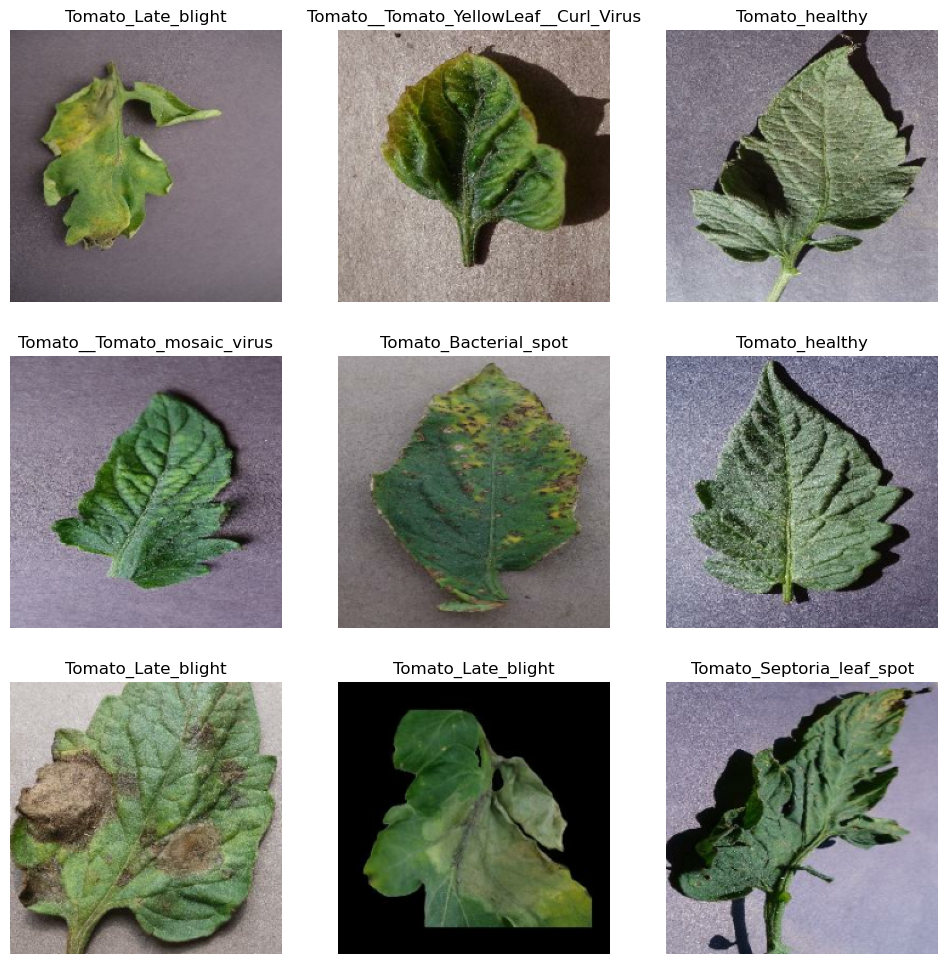

In [141]:
def preview_data(dataset, class_names, num_images=9):
    plt.figure(figsize=(12, 12))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[tf.argmax(labels[i])])
            plt.axis("off")#hide the numbers
    plt.show()

class_names = data.class_names
preview_data(data, class_names)


## 3. Data Cleaning and Preperation

**Cleaning the class names**

In [142]:
#Checking our class names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [143]:
# Cleaning and printing the formarted class names
def clean_class_name(name):
    name = name.replace('__', '_')
    name = name.replace('__', '_')
    if name == 'Tomato_Spider_mites_Two_spotted_spider_mite':
        name = 'Tomato_Spider_mites'
    elif name == 'Tomato_Tomato_YellowLeaf_Curl_Virus':
        name = 'Tomato_Yellow_Leaf_Curl_Virus'
    elif name == 'Tomato_Tomato_mosaic_virus':
        name = 'Tomato_Mosaic_Virus'
    name = name.lower()
    return name

class_names = [clean_class_name(name) for name in class_names]
class_names

['tomato_bacterial_spot',
 'tomato_early_blight',
 'tomato_late_blight',
 'tomato_leaf_mold',
 'tomato_septoria_leaf_spot',
 'tomato_spider_mites',
 'tomato_target_spot',
 'tomato_yellow_leaf_curl_virus',
 'tomato_mosaic_virus',
 'tomato_healthy']

2024-07-21 02:20:53.932779: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


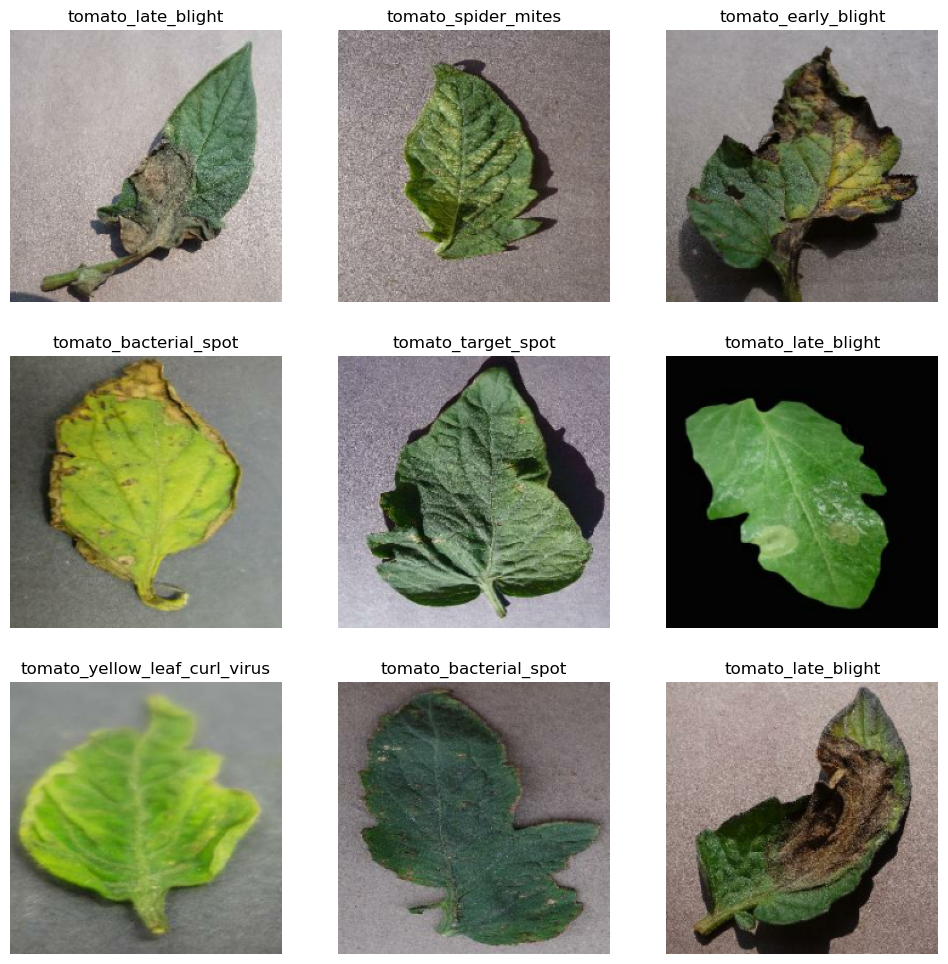

In [144]:
preview_data(data, class_names)

**Checking for Corrupt images**

In [145]:
def check_corrupt_images(folder_path):
    corrupt_images = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            try:
                img = Image.open(os.path.join(root, file))
                img.verify()  # Verify that it is, in fact, an image
            except (IOError, SyntaxError) as e:
                corrupt_images.append(os.path.join(root, file))
    return corrupt_images

corrupt_images = check_corrupt_images(folder_path)
print(f"Found {len(corrupt_images)} corrupt images.")

Found 0 corrupt images.


In [146]:
# Removing Corrupt images
for img_path in corrupt_images:
    try:
      os.remove(img_path)
      print(f"Corrupt image removed:{img_path}")
    except OSError:
      pass

**Class Distribution**

In [147]:
# A function to check class distribution
def check_class_distribution(dataset):
    class_counts = {}
    for images, labels in dataset:
        for label in labels:
            class_name = class_names[tf.argmax(label)]
            if class_name in class_counts:
                class_counts[class_name] += 1
            else:
                class_counts[class_name] = 1
    return class_counts

# Checking class distribution
class_distribution = check_class_distribution(data)

# Sorting the dictionary by values (class counts) in ascending order
sorted_class_distribution = dict(sorted(class_distribution.items(), key=lambda item: item[1]))

print("Sorted class distribution (ascending):", sorted_class_distribution)


Sorted class distribution (ascending): {'tomato_mosaic_virus': 373, 'tomato_leaf_mold': 952, 'tomato_early_blight': 1000, 'tomato_target_spot': 1404, 'tomato_healthy': 1591, 'tomato_spider_mites': 1676, 'tomato_septoria_leaf_spot': 1771, 'tomato_late_blight': 1909, 'tomato_bacterial_spot': 2127, 'tomato_yellow_leaf_curl_virus': 3208}


2024-07-21 02:21:03.310436: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


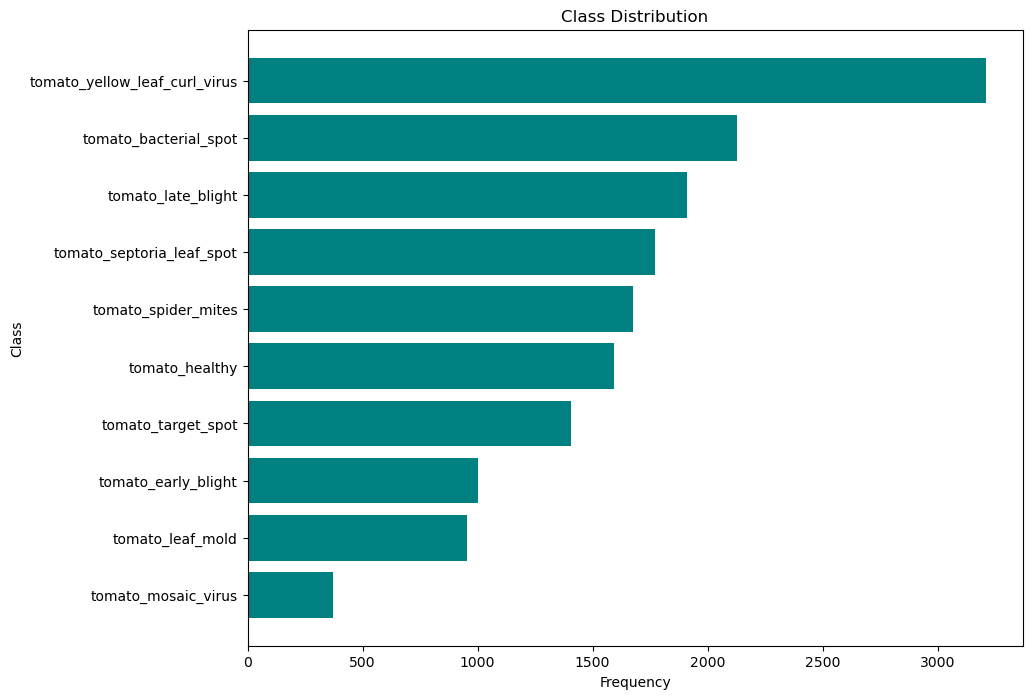

In [148]:
# Visualize class distribution with a horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(list(sorted_class_distribution.keys()), list(sorted_class_distribution.values()), color='Teal')
plt.title('Class Distribution')
plt.xlabel('Frequency')
plt.ylabel('Class')
plt.show();

In our dataset, there is Class imbalance as observed in the graph above, leaf_curl_virus has the highest number of 3208 while tomato mosaic virus with the least observations of 373 as seen on the graph above.

**Splitting our data set**

In [290]:
train_data = tf.keras.utils.image_dataset_from_directory(
    folder_path,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123,  # Set a seed for reproducibility
    validation_split=0.2,  # Use 20% of the data for validation
    subset='training',  # Specify this is the training subset
    interpolation='bilinear'
)

val_data = tf.keras.utils.image_dataset_from_directory(
    folder_path,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
    validation_split=0.2,  # Same split for validation
    subset='validation',  # Specify this is the validation subset
    interpolation='bilinear'
)
test_set = tf.keras.utils.image_dataset_from_directory(
    folder_path,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=False  # Typically set to False for evaluation
)

Found 16011 files belonging to 10 classes.
Using 12809 files for training.
Found 16011 files belonging to 10 classes.
Using 3202 files for validation.
Found 16011 files belonging to 10 classes.


In [291]:
print("Train data element spec:", train_data.element_spec)
print("Validation data element spec:", val_data.element_spec)

Train data element spec: (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))
Validation data element spec: (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))


In [292]:
# Creating a split of our data into train, validation and 80% ,10% and 10% Respectivly
def split_data(data, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle=True, shuffle_size=10000):
  # Calculating the length of our dataset
  data_size = len(data)
  if shuffle:
    data = data.shuffle(shuffle_size) #Shuffling our data
  train_size = int(train_split* len(data))
  val_size = int(val_split*len(data))

  train_set = data.take(train_size)
  val_set = data.skip(train_size).take(val_size)
  test_set = data.skip(train_size).skip(val_size)

  return train_set, val_set, test_set


In [294]:
# # Printing the length of our train, validation and test data
# train_set, val_set, test_set = split_data(data)
# print(len(train_set))
# print(len(val_set))
# print(len(test_set))

# Data Modeling

**Caching our data**

In [206]:
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_set = val_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_set = test_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

**Resizing, Rescaling and Augmentation**

In [295]:
img_size = 224

# Creating an instance to Resize our data
resize_and_rescale = tf.keras.Sequential([
                layers.Resizing(img_size,img_size),
                layers.Rescaling(1.0/255)
])

# Creating a data augmentation instance for our data
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)

])

**Base Model: CNN**

In [296]:
input_shape = (img_size, img_size)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2))
])

/Users/andrewbaraka/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [297]:
# Creating a split of our data into train, validation and 80% ,10% and 10% Respectively
def split_data(data, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle=True, shuffle_size=10000):

  # Calculating the length of our dataset
  data_size = len(data)
  if shuffle:
    data = data.shuffle(shuffle_size) #Shuffling our data
  train_size = int(train_split* len(data))
  val_size = int(val_split*len(data))

  train_set = data.take(train_size)
  val_set = data.skip(train_size).take(val_size)
  test_set = data.skip(train_size + val_size)

  return train_set, val_set, test_set

# Define the get_subset function if it's not defined elsewhere
def get_subset(dataset, fraction):
  """
  Returns a subset of the given dataset.

  Args:
    dataset: The dataset to extract a subset from.
    fraction: The fraction of the dataset to return.

  Returns:
    A subset of the original dataset.
  """
  subset_size = int(len(dataset) * fraction)
  return dataset.take(subset_size)

# Data Subset
train_subset = get_subset(train_set, 1/3)
val_subset = get_subset(val_set, 1/3)
test_subset = get_subset(test_set, 1/3)


In [210]:
print("Train set element spec:", train_set.element_spec)
print("Validation set element spec:", val_set.element_spec)
print("Test set element spec:", test_set.element_spec)

Train set element spec: (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))
Validation set element spec: (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))
Test set element spec: (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))


In [298]:
# Resizing and normalizing images 
def preprocess_data(dataset, image_size=(224, 224)):
    def preprocess_image(image, label):
        image = tf.image.resize(image, image_size)  # Resize images to 224x224
        image = image / 255.0  # Normalize pixel values to [0, 1]
        return image, label

    return dataset.map(preprocess_image)

In [299]:
# apply preprocessing 
train_set = preprocess_data(train_subset)
val_set = preprocess_data(val_subset)
test_set = preprocess_data(test_subset)

In [300]:
# loading MobileNet V2 Model
from tensorflow.keras.applications import MobileNetV2

# Load MobileNet V2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

In [301]:
# Defining mode architecture 
from tensorflow.keras import layers, models

# Create a new model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    # layers.Dense(128, activation='relu'),
    # layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')  # Adjust num_classes to your dataset
])


In [302]:
# Compiling model 
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use 'categorical_crossentropy' for one-hot encoded labels
              metrics=['accuracy'])

In [287]:
model.summary()

Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_22     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 2,236,682 (8.53 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [303]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

ValueError: The filepath provided must end in `.keras` (Keras model format). Received: filepath=best_model.h5

In [304]:
# Training Model
history = model.fit(train_set,  # Adjust batch size as needed
                    validation_data=val_set,
                    epochs=10)  # Adjust the number of epochs as needed

Epoch 1/10


2024-07-21 04:46:40.363784: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:385: Filling up shuffle buffer (this may take a while): 426 of 10000
2024-07-21 04:46:42.161153: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


133/133 ━━━━━━━━━━━━━━━━━━━━ 100s 614ms/step - accuracy: 0.4888 - loss: 1.6349 - val_accuracy: 0.7793 - val_loss: 0.7121
Epoch 2/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 89s 611ms/step - accuracy: 0.8043 - loss: 0.6474 - val_accuracy: 0.8359 - val_loss: 0.5251
Epoch 3/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 82s 569ms/step - accuracy: 0.8438 - loss: 0.4991 - val_accuracy: 0.8555 - val_loss: 0.4380
Epoch 4/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 84s 581ms/step - accuracy: 0.8745 - loss: 0.4246 - val_accuracy: 0.8848 - val_loss: 0.3958
Epoch 5/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 82s 564ms/step - accuracy: 0.8856 - loss: 0.3723 - val_accuracy: 0.8730 - val_loss: 0.3831
Epoch 6/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 83s 571ms/step - accuracy: 0.8918 - loss: 0.3510 - val_accuracy: 0.9082 - val_loss: 0.3341
Epoch 7/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 83s 571ms/step - accuracy: 0.8973 - loss: 0.3353 - val_accuracy: 0.9141 - val_loss: 0.3201
Epoch 8/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 81s 561ms/step - accuracy: 0.9040 - loss: 0.3119 - va

In [219]:
print("Train set element spec:", train_set.element_spec)
print("Validation set element spec:", val_set.element_spec)

Train set element spec: (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))
Validation set element spec: (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))


In [265]:
for images, labels in train_set.take(1):
    print("Image batch shape:", images.shape)  # Should be (batch_size, 224, 224, 3)
    print("Label batch shape:", labels.shape)  # Should be (batch_size, num_classes)

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 10)


2024-07-21 04:19:11.516394: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [305]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(test_set)
print(f'Test accuracy: {test_accuracy:.2f}')

17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 437ms/step - accuracy: 0.9047 - loss: 0.2547
Test accuracy: 0.91


In [273]:
print(f"Number of samples in test set: {len(test_set)}")

Number of samples in test set: 0


In [308]:
# fine tuning model
base_model.trainable = True  # Unfreeze the base model
# Compile the model again after unfreezing
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continue training
history_fine = model.fit(train_set,
                          validation_data=val_set,
                          epochs=5)  # Fine-tune for a few more epochs

Epoch 1/5
133/133 ━━━━━━━━━━━━━━━━━━━━ 401s 3s/step - accuracy: 0.8681 - loss: 0.3926 - val_accuracy: 0.8535 - val_loss: 0.4716
Epoch 2/5
133/133 ━━━━━━━━━━━━━━━━━━━━ 350s 3s/step - accuracy: 0.8954 - loss: 0.3167 - val_accuracy: 0.8574 - val_loss: 0.4436
Epoch 3/5
133/133 ━━━━━━━━━━━━━━━━━━━━ 348s 3s/step - accuracy: 0.9152 - loss: 0.2565 - val_accuracy: 0.8613 - val_loss: 0.4255
Epoch 4/5
133/133 ━━━━━━━━━━━━━━━━━━━━ 349s 3s/step - accuracy: 0.9246 - loss: 0.2218 - val_accuracy: 0.8594 - val_loss: 0.4090
Epoch 5/5
133/133 ━━━━━━━━━━━━━━━━━━━━ 344s 3s/step - accuracy: 0.9363 - loss: 0.1972 - val_accuracy: 0.8770 - val_loss: 0.4102


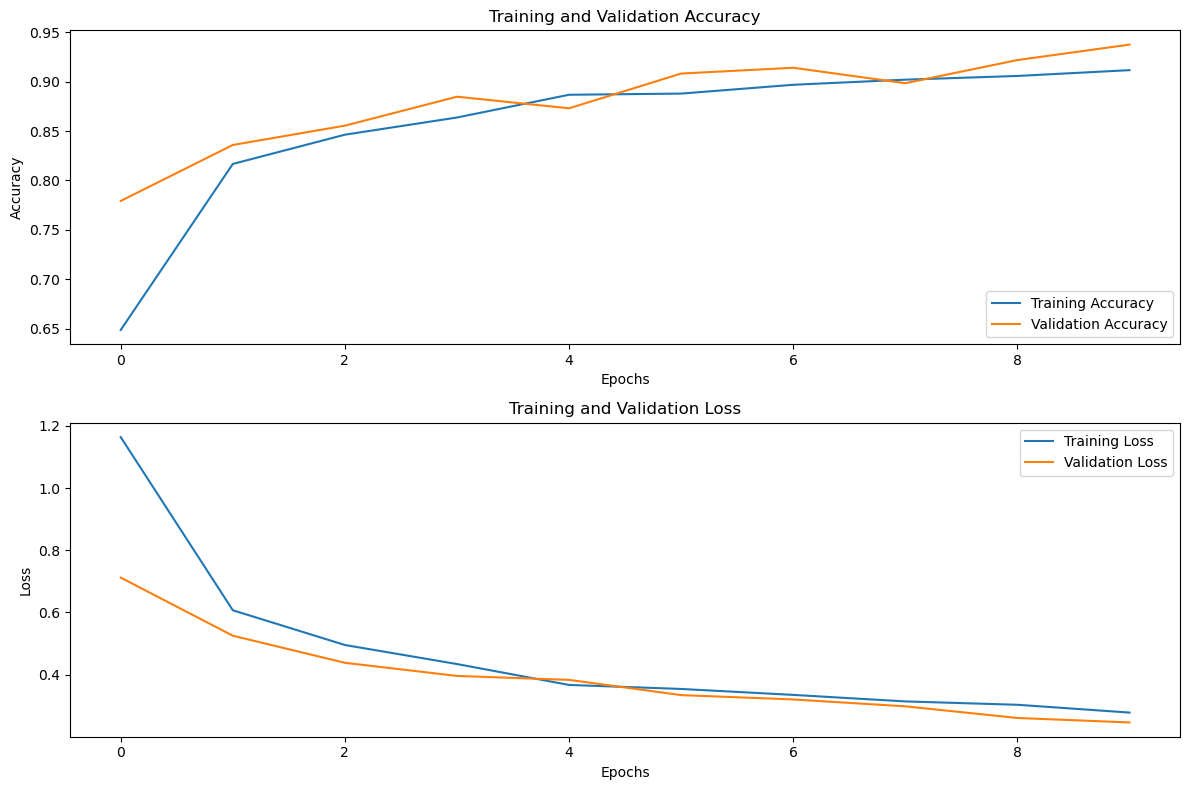

In [310]:
import matplotlib.pyplot as plt

# Extracting accuracy and loss from the history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting Training and Validation Accuracy
plt.figure(figsize=(12, 8))

# Accuracy plot
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

## Interpretation

- The model shows good training progress, with both accuracy increasing and loss decreasing over the epochs.
- The validation accuracy and loss indicate that the model is generalizing well to the validation data, as evidenced by the validation metrics being close to the training metrics.
- There are minor fluctuations in validation accuracy, which is normal and can be attributed to variations in the validation dataset.
- These plots indicate that the model is learning effectively and not overfitting to the training data, as the validation performance is consistent with the training performance.

In [312]:
# save model in keras

model.save('model_name.keras')
history.history
#Recording History in json
import json
with open('history.json','w') as f:
  json.dump(history.history,f)
##Assuming history is the variable name you used while fitting

In [ ]:
# # Importing inception V3 for preprocessing and classification
# inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
# #To make all layers as false in order to use all weights
# for layer in inception.layers:
#     layer.trainable = False

#     #To get classes
#     folders = glob('tomato_disease_dataset/train/*')

In [ ]:
# # prompt: data augmentaion

# data_augmentation = tf.keras.Sequential([
#   layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
#   layers.experimental.preprocessing.RandomRotation(0.2),
# ])
